# 2.2.6 Filtrado de spam en mensajes de texto SMS

In [1]:
%load_ext autoreload
%autoreload 2

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.naive_bayes import BernoulliNB

from sklearn.metrics import confusion_matrix

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings("ignore")

In [5]:
import sys
sys.path.append("../../../") 

from utils.paths import make_dir_line

modality = 'u'
project = 'Analitica predictiva'
data = make_dir_line(modality, project)

raw = data('raw')

Los clasificadores Bayesianos ingenuos son herramientas de gran utilidad para la construcción de sistemas de clasificación, como ya se discutio en los tutoriales anteriores. En este tutorial se utiliza un clasificador Bayesiano ingenuo para determinar si un mensaje SMS es válido o es spam.

## Definición del problema

a recepción de publicidad no deseada a traves mensajes de texto usando SMS (Short Message Service) es un problema que afecta a muchos usuarios de teléfonos móviles. El problema radica en que los usuarios deben pagar por los mesajes recibidos, y por este motivo resulta muy importante que las compañías prestadoras del servicio puedan filtrar mensajes indeseados antes de enviarlos a su destinatario final. Los mensajes tienen una longitud máxima de 160 caracteres, por lo que el texto resulta poco para realizar la clasificación, en comparación con textos más largos (como los emails). Adicionalmente, los errores de digitación dificultan el proceso de detección automática.

La muestra contiene 5574 mensajes en inglés, no codificados y clasificados como legítimos (ham) o spam (http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/). El problema en términos de los datos consiste en clasificar si un mensaje SMS es legítico o spam, a partir del análisis de las palabras que contiente, partiendo del supuesto de que ciertas palabras que son más frecuentes dependiendo del tipo de mensaje. Esto implica que en la fase de preparación de los datos se deben extraer las palabras que contiene cada mensaje para poder realizar el análsis.

## Carga de datos

In [6]:
df = pd.read_csv(
    raw / "sms-spam.csv",
    sep=",",
    encoding="latin-1",
)

df.head()

,type,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
#
# Verifica la lectura de los datos
#
df.describe()

,type,text
count,5574,5574
unique,2,5160
top,ham,"Sorry, I'll call later"
freq,4827,30


## Conteo de cantidad de mensajes por tipo

In [8]:
#
# Se obtiene la cantidad de casos para
# cada tipo de mensaje.
#
df.type.value_counts()

type
ham     4827
spam     747
Name: count, dtype: int64

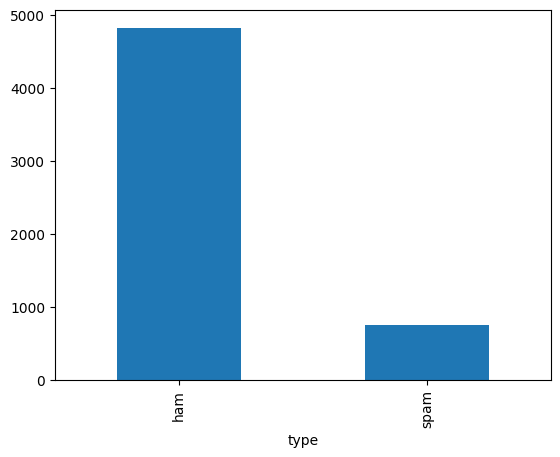

In [9]:
df.type.value_counts().plot.bar();

In [10]:
#
# Se convierte el conteo anterior en probabilidades.
#
round(100 * df.type.value_counts() / sum(df.type.value_counts()), 1)

type
ham     86.6
spam    13.4
Name: count, dtype: float64

## Stemmer

In [13]:
#
# Se construye un stemmer que reduce una palabra a su raiz o 'stem'.
# {llorar, lloramos, lloraron} -> llorar
# {biblioteca, bibliotecario} -> bibliotec
#
stemmer = PorterStemmer()
df["stemmed"] = df.text.apply(lambda x: " ".join([stemmer.stem(w) for w in x.split()]))
df.head(10)

,type,text,stemmed
0,ham,"Go until jurong point, crazy.. Available only ...","go until jurong point, crazy.. avail onli in b..."
1,ham,Ok lar... Joking wif u oni...,ok lar... joke wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri in 2 a wkli comp to win fa cup fina...
3,ham,U dun say so early hor... U c already then say...,u dun say so earli hor... u c alreadi then say...
4,ham,"Nah I don't think he goes to usf, he lives aro...","nah i don't think he goe to usf, he live aroun..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...,freemsg hey there darl it' been 3 week' now an...
6,ham,Even my brother is not like to speak with me. ...,even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...,as per your request 'mell mell (oru minnaminun...
8,spam,WINNER!! As a valued network customer you have...,winner!! as a valu network custom you have bee...
9,spam,Had your mobile 11 months or more? U R entitle...,had your mobil 11 month or more? u r entitl to...


### Matriz de Términos del Documento

In [15]:
#
# Stopwords:
#   i  me  my  myself  we  our  ours  ourselves ....
#   am  is  are  was  were  be  been  being  have
#   has  had  having  do  does  did  doing  ...
#   a  an  the  and  but  if  or  because  as  until
#   while  of  at  by  for  with  about  against ...
#   ...
#
# token_pattern:
# https://docs.python.org/3/howto/regex.html#regex-howto
#
#   \w cualquier caracter alfanumerico [a-zA-Z0-9_]
#   \w\w+ cadenas de dos o mas caracteres
#   \b  word boundary
#
count_vect = CountVectorizer(
    analyzer="word",                # a nivel de palabra
    lowercase=True,                 # convierte a minúsculas
    stop_words="english",           # stop_words en inglés
    token_pattern=r"(?u)\b\w\w+\b", # patrones a reconocer
    binary=True,                    # Los valores distintos de cero son fijados en 1
    max_df=1.0,                     # máxima frecuencia a considerar
    min_df=5,                       # ignora palabras con baja frecuencia
)

#
# Aplica la función al texto
#
dtm = count_vect.fit_transform(df.stemmed)

#
# Las filas contienen los mensajes
# y las clomunas los términos
#
dtm.shape

(5574, 1540)

In [17]:
#
# Palabras aprendidas de los mensajes de texto
#
vocabulary = count_vect.get_feature_names_out()
len(vocabulary)

1540

In [18]:
#
# Primeras palabras del vocabulario
#
vocabulary[0:10]

array(['00', '000', '02', '03', '04', '06', '0800', '08000839402',
       '08000930705', '0870'], dtype=object)

In [24]:
#
# Se puede mejorar diciendo que solo se reconozcan
# palabras formadas por letras
#
count_vect = CountVectorizer(
    analyzer="word",
    lowercase=True,
    stop_words="english",
    token_pattern=r"(?u)\b[a-zA-Z][a-zA-Z]+\b",
    binary=True,
    max_df=1.0,
    min_df=5,
)

dtm = count_vect.fit_transform(df.stemmed)

#
# Las filas contienen los mensajes
# y las clomunas los términos
#
dtm.shape

(5574, 1423)

In [25]:
vocabulary = count_vect.get_feature_names_out()
vocabulary[0:10]

array(['aathi', 'abiola', 'abl', 'abt', 'ac', 'acc', 'accept', 'access',
       'account', 'act'], dtype=object)

In [26]:
#
# Recupera los mensajes de la dtm
#
def dtm2words(dtm, vocabulary, index):
    as_list = dtm[index, :].toarray().tolist()
    docs = []
    for i in index:
        k = [vocabulary[iword] for iword, ifreq in enumerate(as_list[i]) if ifreq > 0]
        docs += [k]
    return docs


for i, x in enumerate(dtm2words(dtm, vocabulary, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])):
    print("Org: ", df.text[i])
    print("Mod: ", " ".join(x))
    print("")

Org:  Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Mod:  avail bugi cine got great la onli point wat world

Org:  Ok lar... Joking wif u oni...
Mod:  joke lar ok wif

Org:  Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
Mod:  appli comp cup entri final free question rate receiv std text txt win wkli

Org:  U dun say so early hor... U c already then say...
Mod:  alreadi dun earli say

Org:  Nah I don't think he goes to usf, he lives around here though
Mod:  don goe live nah think usf

Org:  FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, Â£1.50 to rcv
Mod:  darl freemsg fun hey like ok send std week word xxx

Org:  Even my brother is not like to speak with me. They treat me like aids patent.
Mod:  brother like speak treat

Org: 

### Conjuntos de entrenamiento y prueba

In [27]:
#
# Creación de los conjuntos de entrenamiento y prueba.
#
X_train = dtm[
    0:4168,
]
X_test = dtm[
    4169:,
]

y_train_true = df.type[0:4168]
y_test_true = df.type[4169:]

#
# Distribución de los datos en el conjunto de entrenamiento.
#
round(100 * y_train_true.value_counts() / sum(y_train_true.value_counts()), 1)

type
ham     86.5
spam    13.5
Name: count, dtype: float64

In [28]:
#
# Distribución de los datos en el conjunto de entrenamiento.
#
round(100 * y_test_true.value_counts() / sum(y_test_true.value_counts()), 1)

type
ham     87.0
spam    13.0
Name: count, dtype: float64

### Entrenamiento del modelo

In [53]:
#
# Se crea un clasificador Naive Bayes (NB)
#
clf = BernoulliNB()

#
# Se entrena el clasificador
#
clf.fit(X_train.toarray(), y_train_true)
clf

BernoulliNB()

### Evaluación del modelo

In [54]:
#
# Se pronostica para los datos de prueba.
#
y_test_pred = clf.predict(X_test.toarray())
y_test_pred_prob = clf.predict_proba(X_test.toarray())
y_test_pred

array(['spam', 'ham', 'ham', ..., 'ham', 'ham', 'ham'], dtype='<U4')

In [55]:
#
# Métricas de desempeño
#

confusion_matrix(y_true=y_test_true, y_pred=y_test_pred)

#
# Pronostico en las columnas
# Real en las filas
#

array([[1213,    9],
       [  17,  166]])

In [56]:
clf.predict_proba(X_test.toarray())

array([[2.56782069e-11, 1.00000000e+00],
       [9.97507164e-01, 2.49283632e-03],
       [9.97748935e-01, 2.25106470e-03],
       ...,
       [9.99944765e-01, 5.52350469e-05],
       [9.99580765e-01, 4.19235040e-04],
       [9.99850227e-01, 1.49773007e-04]])

In [57]:
#
# Resulta más conveniente preparar una nueva tabla que
# muestre la clasificación y no únicamente las
# probabilidades.
#
results = pd.DataFrame(
    data={
        "actual_type": y_test_true,
        "predict_type": y_test_pred,
        "prob_ham": [v[0] for v in y_test_pred_prob],
        "prob_spam": [v[1] for v in y_test_pred_prob],
    }
)

results.head(5)

,actual_type,predict_type,prob_ham,prob_spam
4169,spam,spam,2.567821e-11,1.000000e+00
4170,ham,ham,9.975072e-01,2.492836e-03
4171,ham,ham,9.977489e-01,2.251065e-03
4172,ham,ham,1.000000e+00,1.382815e-08
4173,ham,ham,9.999996e-01,4.133793e-07


In [58]:
#
# Mensajes con clasificación errónea.
# Resulta muy importante determinar porque los
# mensajes están mal clasificados
#
results[results["actual_type"] != results["predict_type"]]

,actual_type,predict_type,prob_ham,prob_spam
4213,spam,ham,0.996469,0.003531
4253,ham,spam,0.137255,0.862745
4256,spam,ham,0.831411,0.168589
4295,spam,ham,0.783809,0.216191
4344,ham,spam,0.075089,0.924911
4373,spam,ham,0.950103,0.049897
4394,spam,ham,0.932296,0.067704
4399,ham,spam,0.086534,0.913466
4475,spam,ham,0.619568,0.380432
4514,spam,ham,0.998462,0.001538


In [59]:
#
# Sin embargo, es mucho más intersante extraer
# mensajes con probabilidades numéricamente
# cercanas a 0.5. Estos podrían generar ambiguedad
# en la clasificación.
#
results[(results["prob_spam"] > 0.4) & (results["prob_spam"] < 0.6)]

,actual_type,predict_type,prob_ham,prob_spam
4821,spam,ham,0.582984,0.417016
5056,ham,spam,0.443998,0.556002
5122,spam,spam,0.462431,0.537569


In [60]:
#
# Mensajes mal clasificados con probabilidad cercana a 0.5
#
results[
      (results["prob_spam"] > 0.4)
    & (results["prob_spam"] < 0.6)
    & (results["actual_type"] != results["predict_type"])
]

,actual_type,predict_type,prob_ham,prob_spam
4821,spam,ham,0.582984,0.417016
5056,ham,spam,0.443998,0.556002


In [61]:
print('ok_')

ok_
